In [1]:
from dataset import LIDC, REFUGE
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch

In [2]:
from PIL import Image

img = Image.open('/home/khoi.ho/AI7102/DL_Repo_Interactive_Segmentation/data/REFUGE-Multirater/Training-400/0826/0826.jpg')
img.size

(2124, 2056)

In [2]:
from types import SimpleNamespace
from torchvision import transforms
args = SimpleNamespace()
args.image_size = 256
args.out_size = 256
args.data_path = 'data/LIDC'
transform_train = transform_train = transforms.Compose([
    transforms.Resize((args.image_size,args.image_size)),
    transforms.ToTensor(),
])

In [3]:
refuge_train_dataset = REFUGE(args, args.data_path, transform = transform_train, mode = 'Training')

FileNotFoundError: [Errno 2] No such file or directory: 'data/LIDC/Training-400'

In [3]:
lidc_test_dataset = LIDC(args, args.data_path, transform = transform_train, mode = 'test')

In [4]:
from tqdm import tqdm
img_empty_indices = []
for i in tqdm(range(len(lidc_test_dataset))):
    instance = lidc_test_dataset[i]
    multi_rater = instance['multi_rater']
    layers = multi_rater.shape[0]
    for layer in range(layers):
        if np.sum(np.array(multi_rater[layer])) == 0:
            img_empty_indices.append(i)
            break
print(len(img_empty_indices))
        
    

100%|██████████| 724/724 [00:15<00:00, 46.75it/s]

0


In [10]:
img_non_empty_indices = list(set(range(len(lidc_test_dataset))) - set(img_empty_indices))
np.save('data/LIDC/test_non_empty_indices.npy', np.array(img_non_empty_indices))

In [14]:
instance.keys()

dict_keys(['image', 'multi_rater', 'p_label', 'pt', 'selected_rater', 'not_selected_rater', 'mask', 'mask_ori', 'image_meta_dict'])

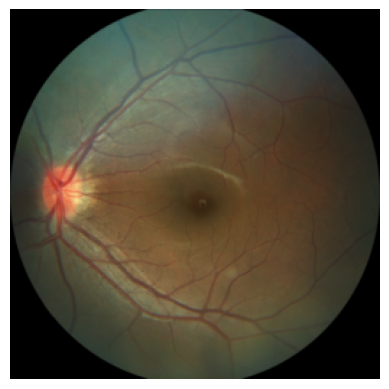

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(instance['image'].permute(1,2,0))
plt.axis('off')
plt.show()

In [18]:
instance['multi_rater'].shape

torch.Size([7, 1, 256, 256])

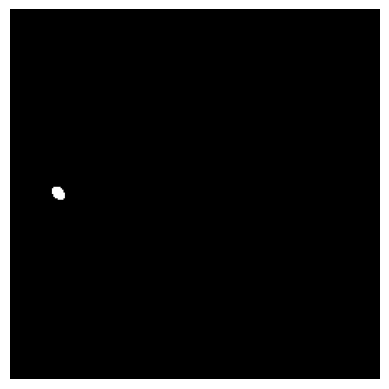

In [23]:
plt.imshow(instance['multi_rater'][6].permute(1,2,0), cmap='gray')
plt.axis('off')
plt.show()

In [28]:
instance['p_label'], instance['pt'], instance['selected_rater'], instance['not_selected_rater']

(1,
 array([126,  33]),
 array([0., 0., 1., 1., 0., 1., 1.]),
 array([1., 1., 0., 0., 1., 0., 0.]))

In [30]:
instance['mask'].shape

torch.Size([1, 256, 256])

In [31]:
instance['mask_ori'].shape

torch.Size([1, 256, 256])

In [33]:
instance['image_meta_dict']

{'filename_or_obj': '1217'}

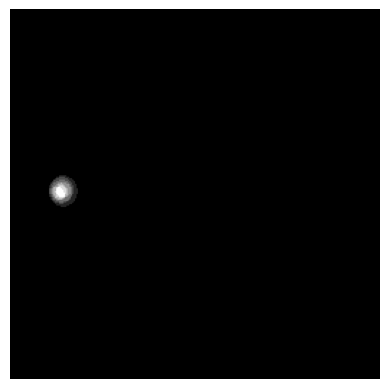

In [38]:
import numpy as np
plt.imshow(np.mean(np.array(instance['multi_rater'].squeeze(1)), axis=0), cmap='gray')
plt.axis('off')
plt.show()

In [86]:
import random
multi_rater_mean = np.mean(np.array(instance['multi_rater'].squeeze(1)), axis=0)
point_label = random.choice(list(set(multi_rater_mean.flatten())))
print(point_label)
if np.random.choice([True, False], 1, p=[0.8,0.2])[0]:
    print("Resample")
    while (point_label == 0) or (point_label == 1):
        point_label = random.choice(list(set(multi_rater_mean.flatten())))
print(point_label)

0.85714287
Resample
0.85714287


In [53]:
np.random.choice([True, False], 1, p=[0.8,0.2])[0]

True

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
from IPython.display import display
import cv2
from tqdm import tqdm
import os

In [208]:
import os
data_path = '/home/khoi.ho/AI7102/DL_Repo_Interactive_Segmentation/data/LIDC'


gt_folder = os.path.join(data_path, 'test', 'gt')
img_folder = os.path.join(data_path, 'test', 'images')

gt_subfolders = []
img_subfolders = []
for f in os.scandir(gt_folder):
    if not f.is_dir():
        continue
    gt_subfolders.append(os.path.join(gt_folder, f.name))
    img_subfolders.append(os.path.join(img_folder, f.name))
    
img_paths = []
gt_paths = []
count = 0
for folder in img_subfolders:
    for f in os.listdir(folder):
        # prefix = f[:-4]
        # img_paths.append(os.path.join(folder, f))
        # gt_paths.append([os.path.join(gt_folder, folder.split('/')[-1], prefix + '_r'+str(i)+'.npy') for i in range(1, 6) 
        #                  if os.path.exists(os.path.join(gt_folder, folder.split('/')[-1], prefix + '_r'+str(i)+'.npy'))])
        count += 1
print(count)
print(len(img_paths)); print(len(gt_paths))

1980
0
0


In [104]:
gt_paths[0]

['/home/khoi.ho/AI7102/DL_Repo_Interactive_Segmentation/data/MBHSeg-Multi/train/gt/ID_338738e7_ID_0808281b2a/slice_6_r1.npy',
 '/home/khoi.ho/AI7102/DL_Repo_Interactive_Segmentation/data/MBHSeg-Multi/train/gt/ID_338738e7_ID_0808281b2a/slice_6_r3.npy']

In [105]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

img_path = img_paths[60]
gt_path = gt_paths[60]

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

img = Image.open(img_path).convert('RGB')
multi_rater = []
for path in gt_path:
    arr = np.load(path)
    m = torch.from_numpy(arr).permute(2, 0, 1).float()
    multi_rater.append(m)
    
state = torch.get_rng_state()
img = transform(img)
multi_rater_cup = []
H, W = img.shape[-2], img.shape[-1]

multi_rater = [transforms.functional.resize(m, (H, W), interpolation=transforms.InterpolationMode.NEAREST) for m in multi_rater]
multi_rater = [(m > 0.5).float() for m in multi_rater]
multi_rater = torch.stack(multi_rater, dim=0)

In [170]:
import numpy as np
import random
import torch
import torch.nn.functional as F

def random_click_multiclass(multi_rater: torch.Tensor):
    """
    multi_rater: (R, C, H, W), one-hot; 0=BG, 1..C-1=FG
    Return:
      point_label (int),
      pt (np.array [y,x]),
      selected_rater (np[R] 0/1),
      not_selected_rater (np[R] 0/1),
      selected_rater_mask (torch.FloatTensor [C,H,W], one-hot)
    """
    assert multi_rater.ndim == 4, "Expect (R, C, H, W)"
    R, C, H, W = multi_rater.shape
    device = multi_rater.device

    present_any = (multi_rater > 0.5).any(dim=0)          # (C,H,W) bool
    present_any_np = present_any.detach().cpu().numpy()
    
    diver_mask = (present_any.sum(dim=0) >= 2)
    diver_mask_np = diver_mask.detach().cpu().numpy()
    fg_classes = list(range(1, C))
    fg_in_div = [c for c in fg_classes if np.any(present_any_np[c] & diver_mask_np)]
    print(fg_in_div)

    if len(fg_in_div)>0 and random.random() < 0.8:
        point_label = int(random.choice(fg_in_div))
    else:
        fg_present = [c for c in fg_classes if present_any[c].any().item()]
        point_label = int(random.choice(fg_present)) if fg_present else 0
        
    if point_label != 0:
        cand = np.argwhere(present_any_np[point_label] & diver_mask_np)
        if len(cand) == 0:
            cand = np.argwhere(present_any_np[point_label])
    else:
        cand = np.argwhere(diver_mask_np)
        if len(cand) == 0:
            cand = np.argwhere(present_any_np[0])
        if len(cand) == 0:
            cand = np.array([[np.random.randint(H), np.random.randint(W)]], dtype=np.int64)

    pt = cand[np.random.randint(len(cand))]
    y, x = int(pt[0]), int(pt[1])

    counts_at_pt = (multi_rater[:, :, y, x] > 0.5).sum(dim=0)   # (C,)
    present_at_pt = torch.nonzero(counts_at_pt > 0, as_tuple=False).squeeze(1).tolist()

    if present_at_pt:
        fg_present_at_pt = [c for c in present_at_pt if c != 0]
        if fg_present_at_pt:
            fg_counts = counts_at_pt[fg_present_at_pt]                  # (#fg,)
            max_fg = int(fg_counts.max().item())
            tie_idxs = (fg_counts == max_fg).nonzero(as_tuple=False).squeeze(1).tolist()
            maj_fg = int(fg_present_at_pt[random.choice(tie_idxs)])     # break tie trong FG
            if random.random() < 0.8:
                point_label = maj_fg
            else:
                fg_others = [c for c in fg_present_at_pt if c != maj_fg]
                point_label = int(random.choice(fg_others)) if fg_others else maj_fg
        else:
            point_label = 0
    else:
        point_label = 0


    sel_idx = torch.nonzero(multi_rater[:, point_label, y, x] > 0.5, as_tuple=False).squeeze()
    if sel_idx.ndim == 0 and sel_idx.numel() > 0:
        sel_idx = torch.tensor([sel_idx.item()], device=device)
    if sel_idx.numel() == 0:

        sel_idx = torch.arange(R, device=device)

    not_sel_idx = torch.tensor([i for i in range(R) if i not in set(sel_idx.tolist())],
                               device=device, dtype=torch.long)

    sel_mask_soft = multi_rater[sel_idx].float().mean(dim=0)     # (C,H,W)
    label_map = sel_mask_soft.argmax(dim=0)                      # (H,W)
    selected_rater_mask = F.one_hot(label_map, num_classes=C).permute(2,0,1).float().to(device)

    # Vectors 0/1
    selected_rater = np.zeros(R, dtype=np.float32)
    not_selected_rater = np.zeros(R, dtype=np.float32)
    if sel_idx.numel() > 0:
        selected_rater[sel_idx.detach().cpu().numpy()] = 1.0
    if not_sel_idx.numel() > 0:
        not_selected_rater[not_sel_idx.detach().cpu().numpy()] = 1.0

    return int(point_label), pt, selected_rater, not_selected_rater, selected_rater_mask



In [168]:
multi_rater[:,:,64,108]

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [198]:
img = Image.fromarray(random_click_multiclass(multi_rater)[4][5].numpy()*255).convert('L')

[5]


In [200]:
random_click_multiclass(multi_rater)

[5]


(5,
 array([ 46, 106]),
 array([0., 0., 1.], dtype=float32),
 array([1., 1., 0.], dtype=float32),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
        